In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import itertools
import scipy.cluster.hierarchy as sch

from __init__ import *
from CEMBA_update_mysql import connect_sql 

# To-dos:

- Add statistical test

In [2]:
log = logging.getLogger()
log.setLevel(logging.WARNING)

logging.info('Hello!')

In [3]:
def get_mcc(df, base_call_cutoff=100, sufficient_coverage_fraction=1):
    """Get mcc matrix from mc_c matrix (filtering out low coverage gene or bins)
    """
    logging.info('Getting mcc matrix from mc and c') 
    logging.info('base_call_cutoff={}, sufficient_coverage_fraction={}'.format(
                base_call_cutoff, sufficient_coverage_fraction))
    
    df_c = df.filter(regex="_c$")
    df_c.columns = [col[:-len('_c')] for col in df_c.columns] 
    df_mc = df.filter(regex="_mc$")
    df_mc.columns = [col[:-len('_mc')] for col in df_mc.columns] 
    # a gene is sufficiently covered in % of cells 
    condition = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*(df.shape[1])/2.0 

    logging.info("Matrix size before pruning... "+ str(df.shape))
    logging.info("Matrix size after pruning... "+ str(df.loc[condition].shape))
    
    # get mcc matrix with kept bins and nan values for low coverage sites
    df_c_nan = df_c.copy()
    df_c_nan[df_c < base_call_cutoff] = np.nan
    df_mcc = df_mc.loc[condition]/df_c_nan.loc[condition]
    logging.info(df_mcc.shape)

    # imputation (missing value -> mean value of all cells)
    logging.info('Imputing data... (No effect if sufficient_coverage_fraction=1)')
    means = df_mcc.mean(axis=1)
    fill_value = pd.DataFrame({col: means for col in df_mcc.columns})
    df_mcc.fillna(fill_value, inplace=True)
    
    # add suffix
    df_mcc.columns = df_mcc.columns.values + '_mcc'
    
    return df_mcc


In [4]:
def get_cluster_mc_c_worker(df_cells, df_input, cluster_col):
    """reduce gene*cell or bin*cell matrix to a gene*cluster or bin*cluster matrix
    Arguments:
        - df_cells: a dataframe indexed by 'cell_name', and have '$cluster_col' as column
        - df_input: a dataframe with 'sample_mc', 'sample_c' ... as columns
        sample names are cell names
    """
    # cluster mc_c
    df_c = df_input.filter(regex='_c$')
    df_mc = df_input.filter(regex='_mc$')

    df_mc_c = pd.DataFrame() 
    for label, df_sub in df_cells.groupby(cluster_col):
        samples = df_sub.index.values
        df_mc_c['{}_mc'.format(label)] = df_mc[samples+'_mc'].sum(axis=1)
        df_mc_c['{}_c'.format(label)] = df_c[samples+'_c'].sum(axis=1)

    logging.info("Output shape: {}".format(df_mc_c.shape))
    return df_mc_c


In [5]:
f = os.path.join(PATH_ENSEMBLES, 'Ens10', 'gene_level', 'genebody_mCH_Ens10.tsv.bgz')
df = pd.read_table(f, index_col='gene_id', compression='gzip')
print(df.shape)
df.head()

f = os.path.join(PATH_ENSEMBLES, 'Ens10', 'gene_level', 'genebody_mCG_Ens10.tsv.bgz')
df_mcg = pd.read_table(f, index_col='gene_id', compression='gzip')
print(df_mcg.shape)
df_mcg.head()

(51772, 10704)
(51772, 10704)


,171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD001_indexed_mc,171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD001_indexed_c,171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD002_indexed_mc,171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD002_indexed_c,171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD004_indexed_mc,171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD004_indexed_c,171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD007_indexed_mc,171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD007_indexed_c,171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD008_indexed_mc,171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD008_indexed_c,...,180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_H9_AD006_indexed_mc,180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_H9_AD006_indexed_c,180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_H9_AD007_indexed_mc,180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_H9_AD007_indexed_c,180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_H9_AD008_indexed_mc,180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_H9_AD008_indexed_c,180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_H9_AD010_indexed_mc,180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_H9_AD010_indexed_c,180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_H9_AD012_indexed_mc,180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_H9_AD012_indexed_c
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000102693.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000064842.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000051951.5,129,151,126,164,122,159,72,107,115,144,...,105,137,73,93,71,91,85,100,93,108
ENSMUSG00000102851.1,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000103377.1,2,2,1,1,1,3,0,0,0,0,...,0,0,1,1,4,4,0,0,1,1


In [6]:
database = 'CEMBA'
ens = 'Ens10'
cluster_type = 'mCHmCG_lv_npc50_k5'
engine = connect_sql(database)
sql = """SELECT * FROM genes"""
df_genes = pd.read_sql(sql, engine, index_col='gene_id')
print(df_genes.shape)
df_genes.head()

sql = """SELECT cell_name, cluster_{}, annotation_{} FROM {}
JOIN cells ON {}.cell_id = cells.cell_id""".format(cluster_type, cluster_type, ens, ens)
df_cells = pd.read_sql(sql, engine, index_col='cell_name')
print(df_cells.shape)
df_cells.head()

(53379, 6)
(5352, 2)


,cluster_mCHmCG_lv_npc50_k5,annotation_mCHmCG_lv_npc50_k5
cell_name,,
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD001_indexed,31,mL2/3
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD002_indexed,23,mL5-1
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD004_indexed,21,mL4
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD007_indexed,24,mL2/3
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD008_indexed,47,mL4


In [7]:
df_annot = df_cells.groupby('cluster_'+cluster_type).first().fillna('Glia/unlabeled')
df_annot.head()

,annotation_mCHmCG_lv_npc50_k5
cluster_mCHmCG_lv_npc50_k5,
1,mL6-2
2,mDL-2
3,mL4
4,mL6-2
5,mL2/3


In [8]:
df_mc_c_mcg = get_cluster_mc_c_worker(df_cells, df_mcg, 'cluster_'+cluster_type)
print(df_mc_c_mcg.shape)
df_mcc_mcg = get_mcc(df_mc_c_mcg, base_call_cutoff=20)
print(df_mcc_mcg.shape)
# df_mcc.head()
# df_mc_c.head()

(51772, 176)
(16545, 88)


In [9]:
# normalize and rank percentile

def pairwise_markers(c1, c2, data_pct, low_p=0.02, high_p=0.80): 
    """data_pct: percentile ranking of columns
        c1 and c2 are columns in data_pct
    """
    df_tmp = data_pct.loc[((data_pct[c1] < low_p) & (data_pct[c2] > high_p) 
                           | (data_pct[c1] > high_p) & (data_pct[c2] < low_p)), [c1, c2]]
    n_diff = df_tmp.shape[0]
#     df_tmp['abs_diff'] = np.abs(data[c2] - data[c1])
    return n_diff

def pairwise_markers_allpairs(data_pct):
    """return a dataframe with columns:
        - c1
        - c2
        - num
    """
    num_genes = []
    for i, (c1, c2) in enumerate(itertools.combinations(data_pct.columns, 2)):
        if i % 100 == 1:
            logging.info("Progress: {}".format(i+1))
        num = pairwise_markers(c1, c2, data_pct)
        num_genes.append({'c1': c1, 'c2': c2, 'num': num})
    num_genes = pd.DataFrame(num_genes)
    return num_genes

In [11]:
def merge_clusters(c1_c, c1_mc, c2_c, c2_mc, d, df_mc_c, Z):
    """df_mc_c
    c1_c, c1_mc, c2_c, c2_mc are 4 clusters
    
    return: - merged cluster (cluster name starts from 1)
    """
    n = int(len(df_mc_c.columns)/2)
    df_mc_c['{}_mc'.format(n+1)] = df_mc_c[c1_mc] + df_mc_c[c2_mc]
    df_mc_c['{}_c'.format(n+1)] = df_mc_c[c1_c] + df_mc_c[c2_c]
    Z.append({'c1': c1, 
              'c2': c2, 
              'cnew': n+1, 
              'distance': d})
    
    return n+1

# hierarchical clustering v1

In [12]:
# initialization
Z = []
df_mc_c = get_cluster_mc_c_worker(df_cells, df, 'cluster_'+cluster_type)
current_cols = df_mc_c.columns.tolist() # ('1_mc', '1_c', '2_mc', '2_c' ...)
print(len(current_cols))

03/24/2018 03:52:52 PM Output shape: (51772, 176)


176


In [26]:
# hierarchical clustering v1
# keep updating Z, df_mc_c, and current_cols
ti = time.time()

i = 0
while len(current_cols) > 2: # enter the loop as long as it's not the last current column
    i += 1
    logging.info('Progress: {}'.format(i))
    if i%20 == 0:
        print('.')
    else:
        print('.', end='')
    
    
    df_mcc = get_mcc(df_mc_c[current_cols])
    data = df_mcc.apply(lambda x: zscore(x, ddof=1), axis=1)
    data_pct = data.rank(pct=True, axis=0)

    num_genes = pairwise_markers_allpairs(data_pct)
    res = num_genes.loc[num_genes['num'].idxmin(), :]
    c1 = int(res['c1'].strip('_mcc')) 
    c2 = int(res['c2'].strip('_mcc')) 
    d = int(res['num'])
    cnew = merge_clusters(str(c1)+'_c', str(c1)+'_mc', str(c2)+'_c', str(c2)+'_mc', d, df_mc_c, Z)

    # update
    current_cols.remove(str(c1)+'_c')
    current_cols.remove(str(c1)+'_mc')
    current_cols.remove(str(c2)+'_c')
    current_cols.remove(str(c2)+'_mc')
    current_cols += [str(cnew)+'_mc', str(cnew)+'_c']

print(time.time() - ti)

1,2,3,4,5,6,7,8,9,10
11,12,13,14,15,16,17,18,19,20
21,22,23,24,25,26,27,28,29,30
31,32,33,34,35,36,37,38,39,40
41,42,43,44,45,46,47,48,49,50
51,52,53,54,55,56,57,58,59,60
61,62,63,64,65,66,67,68,69,327.2626450061798


# hierarchical clustering v2 

In [10]:
def initialize(df, df_cells, cluster_col, base_call_cutoff=100):
    Z = []
    df_mc_c = get_cluster_mc_c_worker(df_cells, df, cluster_col)
    current_cols = df_mc_c.columns.tolist() # ('1_mc', '1_c', '2_mc', '2_c' ...)
    current_clusters = np.unique([int(col[:-len('_c')]) for col in df_mc_c.columns if col.endswith('_c')]).tolist() 
    num_clusters = len(current_clusters)

    global_level = df_mc_c.filter(regex='_mc$').sum(axis=1).divide(df_mc_c.filter(regex='_c$').sum(axis=1))

    df_mcc = get_mcc(df_mc_c[current_cols], base_call_cutoff=base_call_cutoff)
    used_index = df_mcc.index
    data = df_mcc.divide(global_level.loc[used_index], axis=0)
    data_pct = data.rank(pct=True, axis=0)
    
    return df_mc_c, df_mcc, data, data_pct, current_cols, current_clusters, num_clusters, global_level, used_index

In [11]:
# (df_mc_c, df_mcc, data, data_pct, current_cols, 
#  current_clusters, num_clusters, global_level, used_index) = initialize(df, df_cells, 
#                                                                         'cluster_'+cluster_type, base_call_cutoff=100)
(df_mc_c, df_mcc, data, data_pct, current_cols, 
 current_clusters, num_clusters, global_level, used_index) = initialize(df_mcg, df_cells, 
                                                                        'cluster_'+cluster_type, base_call_cutoff=20)

In [12]:
# initialization 2
Z = []
df_mc_c = get_cluster_mc_c_worker(df_cells, df, 'cluster_'+cluster_type)
current_cols = df_mc_c.columns.tolist() # ('1_mc', '1_c', '2_mc', '2_c' ...)
current_clusters = np.unique([int(col[:-len('_c')]) for col in df_mc_c.columns if col.endswith('_c')]).tolist() 
num_clusters = len(current_clusters)
print(len(current_cols))
print(len(current_clusters))

176
88


In [13]:
# initialization 2

# df_mcc = get_mcc(df_mc_c[current_cols])
# data = df_mcc.apply(lambda x: zscore(x, ddof=1), axis=1)
global_level = df_mc_c.filter(regex='_mc$').sum(axis=1).divide(df_mc_c.filter(regex='_c$').sum(axis=1))

df_mcc = get_mcc(df_mc_c[current_cols])
used_index = df_mcc.index
data = df_mcc.divide(global_level.loc[used_index], axis=0)
data_pct = data.rank(pct=True, axis=0)

## deviation 1: plot using heatmap of pairwise markers

In [12]:
(df_mc_c, df_mcc, data, data_pct, current_cols, 
 current_clusters, num_clusters, global_level, used_index) = initialize(df, df_cells, 
                                                                        'cluster_'+cluster_type, base_call_cutoff=100)
num_genes_mch = pairwise_markers_allpairs(data.rank(pct=True, axis=0))
num_genes_mch['c1'] = [int(c1.strip('_mcc')) for c1 in num_genes_mch['c1']]
num_genes_mch['c2'] = [int(c2.strip('_mcc')) for c2 in num_genes_mch['c2']]

(df_mc_c, df_mcc, data, data_pct, current_cols, 
 current_clusters, num_clusters, global_level, used_index) = initialize(df_mcg, df_cells, 
                                                                        'cluster_'+cluster_type, base_call_cutoff=20)
num_genes_mcg = pairwise_markers_allpairs(data.rank(pct=True, axis=0))
num_genes_mcg['c1'] = [int(c1.strip('_mcc')) for c1 in num_genes_mcg['c1']]
num_genes_mcg['c2'] = [int(c2.strip('_mcc')) for c2 in num_genes_mcg['c2']]

In [13]:
num_genes = pd.merge(num_genes_mch.rename(columns={'num': 'num_mCH'}), 
         num_genes_mcg.rename(columns={'num': 'num_mCG'}), on=['c1', 'c2'])
num_genes['num'] = (num_genes['num_mCH'] 
                    + num_genes['num_mCG'])
# num_genes['num_1'] = (num_genes['num_mCH']/num_genes['num_mCH'].sum() 
#                     + num_genes['num_mCG']/num_genes['num_mCG'].sum())
num_genes.head()

,c1,c2,num_mCH,num_mCG,num
0,1,2,289,205,494
1,1,3,419,257,676
2,1,4,1,22,23
3,1,5,555,237,792
4,1,6,214,396,610


In [59]:
# num_genes_complete
channel='num'

num_genes_pivot = num_genes.append(
    num_genes.rename(columns={'c1': 'c2', 'c2': 'c1'})).pivot(values=channel, index='c1', columns='c2').fillna(0)
print(num_genes_pivot.shape)
num_genes_pivot.head()

(88, 88)


c2,1,2,3,4,5,6,7,8,9,10,...,79,80,81,82,83,84,85,86,87,88
c1,,,,,,,,,,,,,,,,,,,,,
1,0.0,494.0,676.0,23.0,792.0,610.0,750.0,808.0,741.0,668.0,...,607.0,785.0,207.0,500.0,574.0,432.0,574.0,704.0,333.0,724.0
2,494.0,0.0,618.0,469.0,588.0,661.0,481.0,749.0,456.0,505.0,...,373.0,846.0,514.0,481.0,598.0,498.0,321.0,703.0,455.0,693.0
3,676.0,618.0,0.0,671.0,156.0,538.0,366.0,181.0,301.0,51.0,...,319.0,788.0,717.0,152.0,634.0,419.0,571.0,767.0,633.0,720.0
4,23.0,469.0,671.0,0.0,802.0,586.0,696.0,779.0,708.0,666.0,...,571.0,793.0,207.0,474.0,572.0,433.0,571.0,704.0,368.0,761.0
5,792.0,588.0,156.0,802.0,0.0,678.0,124.0,236.0,75.0,163.0,...,434.0,725.0,719.0,426.0,688.0,502.0,401.0,655.0,656.0,652.0


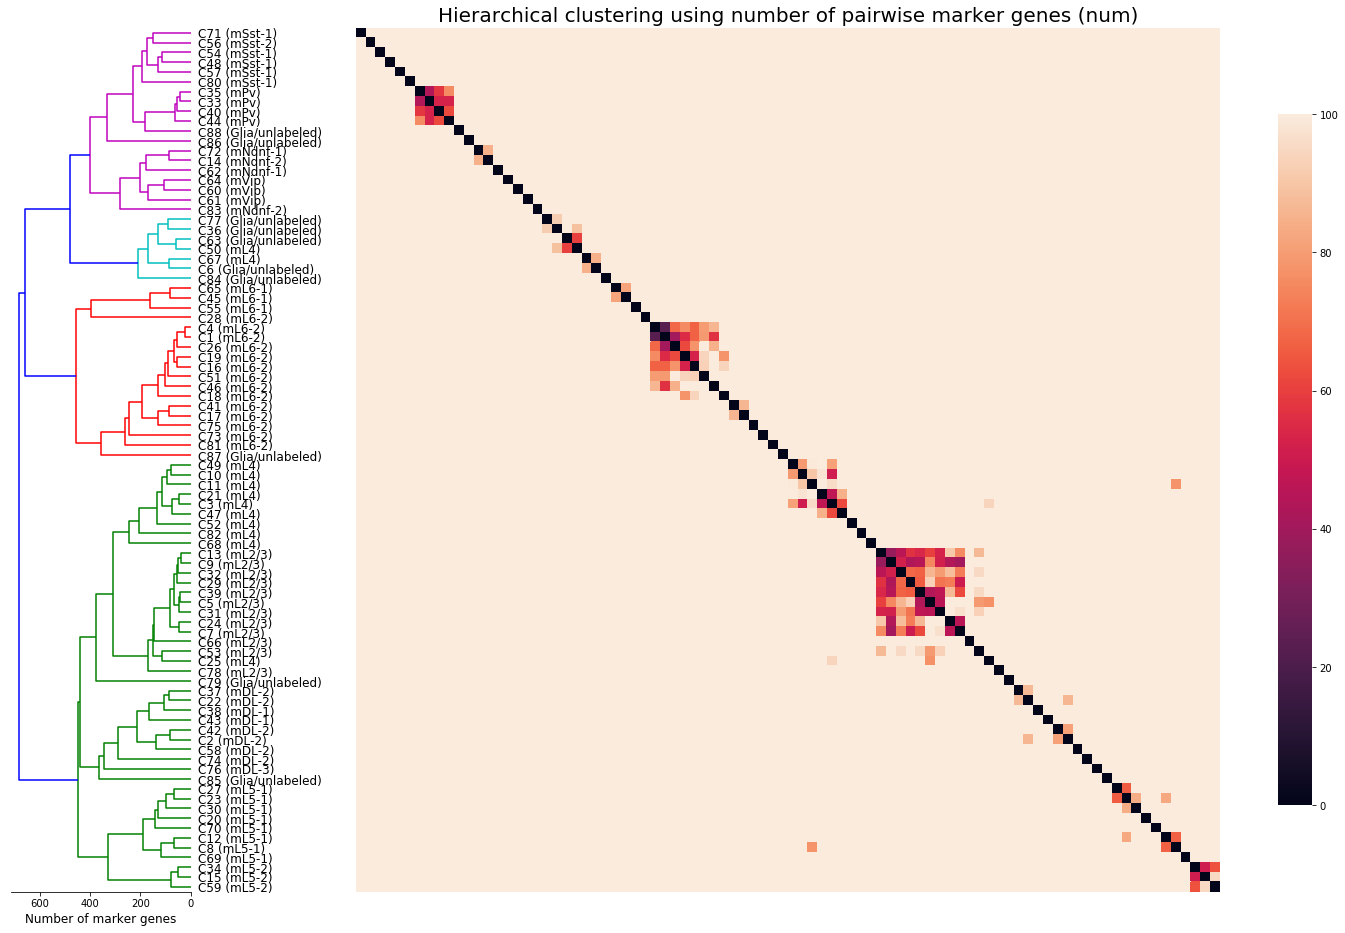

In [62]:
# use a 1d distance matrix (num_genes) for hierarchical clustering
# uncompressed 2d distance matrix as heatmap visualization

margin = 0.1
fig = plt.figure(figsize=(17/(1-margin*2), 12/(1-margin*2)))
# plot1
# # how they order the 1d distance matrix: (0, 1), (0, 2), (1, 2)
ax = fig.add_axes([margin, margin, 2.5/17.0*(1-margin*2), 1-margin*2])
ax2 = fig.add_axes([margin+4/17.0*(1-margin*2), margin, 16/17.0*(1-margin*2), 1-margin*2])
Z = sch.linkage(num_genes[channel].values, method='average')
# Z[:, 2] = np.log2(Z[:, 2])
sch.dendrogram(Z, orientation='left', ax=ax)
cluster_order = [int(i.get_text())+1 for i in ax.get_yticklabels()]
ax.set_yticklabels(
    ['C{} ({})'.format(int(label.get_text())+1, df_annot.loc[int(label.get_text())+1, 'annotation_'+cluster_type])
     for label in ax.get_yticklabels()], 
    fontsize=12)
ax.set_xlabel('Number of marker genes', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# plot2
ax = ax2
mask = np.zeros_like(num_genes_pivot.values)
mask[np.triu_indices_from(mask, k=1)] = False # True if we want to mask upper triangle
sns.heatmap(num_genes_pivot.loc[reversed(cluster_order), reversed(cluster_order)], 
#             cmap='viridis', 
            vmax=100,
            mask=mask, square=True, cbar_kws={'shrink': 0.8}, ax=ax)
ax.set_title("Hierarchical clustering using number of pairwise marker genes ({})".format(channel), fontsize=20)
ax.axis('off')
fig.savefig('/cndd/fangming/integration/88_clusters_dendro_heatmap_{}.pdf'.format(channel))
plt.show()

/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/ipykernel_launcher.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  after removing the cwd from sys.path.


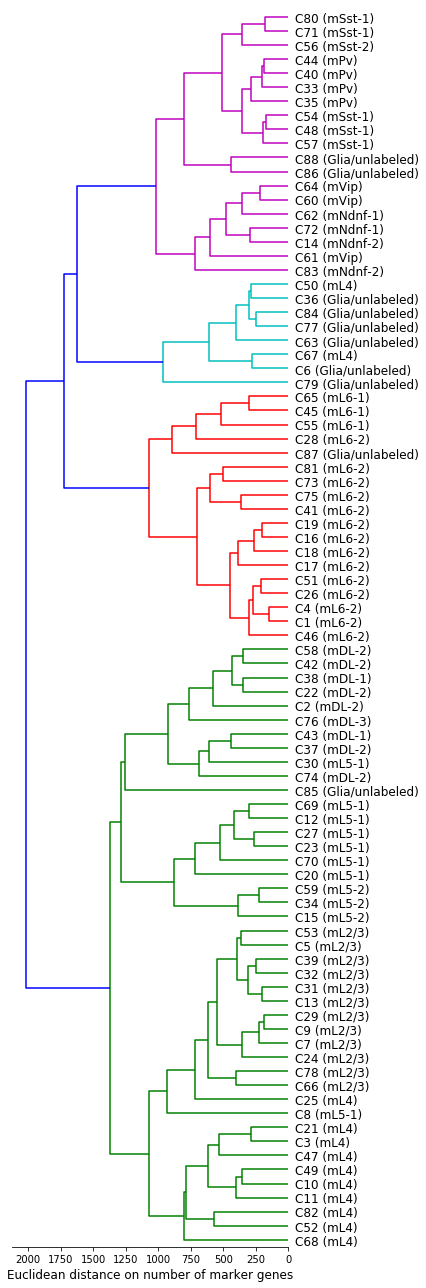

In [98]:
# dendrogram on heatmap
fig, ax = plt.subplots(figsize=(6, 18))
sch.dendrogram(sch.linkage(num_genes_pivot, method='average', metric='euclidean'), orientation='left', ax=ax)
ax.set_yticklabels(
    ['C{} ({})'.format(int(label.get_text())+1, df_annot.loc[int(label.get_text())+1, 'annotation_'+cluster_type])
     for label in ax.get_yticklabels()], 
    fontsize=12)
ax.set_xlabel('Euclidean distance on number of marker genes', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
fig.tight_layout()
plt.show()

/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


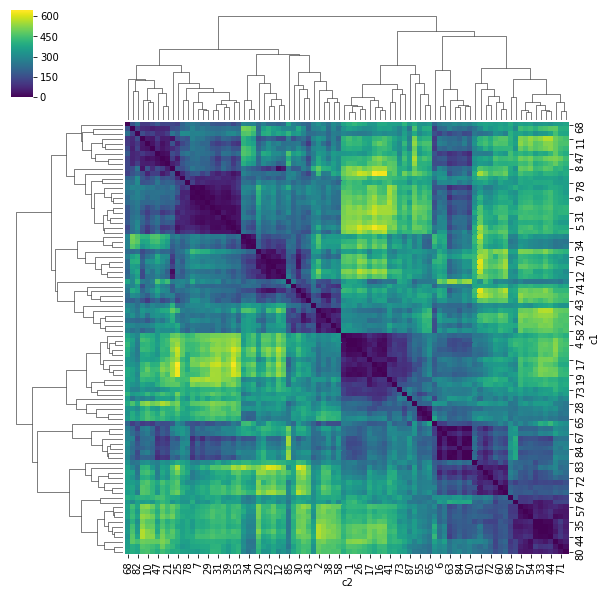

In [17]:
sns.clustermap(num_genes_pivot, cmap='viridis')
plt.show()

## end of deviation 1: plot using heatmap of pairwise markers

In [80]:
# hierarchical clustering v2
# keep updating Z, df_mc_c, and current_cols

ti = time.time()

i = 0
while len(current_cols) > 2: # enter the loop as long as it's not the last current column
    i += 1
    logging.info('Progress: {}'.format(i))
    if i%20 == 0:
        print('.')
    else:
        print('.', end='')
    
    
#     df_mcc = get_mcc(df_mc_c[current_cols])
#     data = df_mcc.apply(lambda x: zscore(x, ddof=1), axis=1)
#     data_pct = data.rank(pct=True, axis=0)

    num_genes = pairwise_markers_allpairs(data_pct)
    res = num_genes.loc[num_genes['num'].idxmin(), :]
    c1 = int(res['c1'].strip('_mcc')) 
    c2 = int(res['c2'].strip('_mcc')) 
    d = int(res['num'])
    cnew = merge_clusters(str(c1)+'_c', str(c1)+'_mc', str(c2)+'_c', str(c2)+'_mc', d, df_mc_c, Z)

    # update: current_cols, current_clusters
    current_cols.remove(str(c1)+'_c')
    current_cols.remove(str(c1)+'_mc')
    current_cols.remove(str(c2)+'_c')
    current_cols.remove(str(c2)+'_mc')
    current_cols += [str(cnew)+'_mc', str(cnew)+'_c']
    
    current_clusters.append(cnew)
    current_clusters.remove(c1)
    current_clusters.remove(c2)
    
    # update: df_mc_c and data_pct
    # df_mc_c has been updated inside the "merge_clusters" function
    # update data_pct:
    data_pct = data_pct.drop([str(c1)+'_mcc', str(c2)+'_mcc'], axis=1)
    data_pct[str(cnew)+'_mcc'] = ((df_mc_c[str(cnew)+'_mc']/df_mc_c[str(cnew)+'_c']).loc[used_index].divide(
                    global_level.loc[used_index])).rank(pct=True)

print(time.time() - ti)

....................
....................
....................
....................
.......268.52719235420227


In [33]:
# add statistical test

In [81]:
Z = pd.DataFrame(Z)
print(Z.shape)
Z.head()

(87, 4)


,c1,c2,cnew,distance
0,50,63,89,0
1,36,89,90,0
2,1,4,91,1
3,33,35,92,2
4,44,92,93,2


In [101]:
# monolize Z distance and 
# organize it to the standard linkage format 

cmax = 0
d_mono = []
for i in Z['distance']:
    if i < cmax:
        d_mono.append(cmax)
    else:
        d_mono.append(i)
        cmax = i
Z_mono = Z.copy()
Z_mono['c1'] = Z['c1'] - 1
Z_mono['c2'] = Z['c2'] - 1
Z_mono['distance'] = d_mono
Z_mono['cnew'] = Z['cnew'] - 1 

In [103]:
# calculate number of original clusters given a Z
Z_mono['num_orig_clusters'] = 0
num_orig_clusters = []
for idx, row in Z_mono.iterrows():
    if row['c1'] < num_clusters:
        num_c1 = 1
    else:
        try:
            num_c1 = num_orig_clusters[row['c1'] - num_clusters]
        except:
            raise ValueError("num_c1 not found!")
            
    if row['c2'] < num_clusters:
        num_c2 = 1
    else:
        try:
            num_c2 = num_orig_clusters[row['c2'] - num_clusters]
        except:
            raise ValueError("num_c2 not found!")
    num_orig_clusters.append(num_c1 + num_c2)
Z_mono['num_orig_clusters'] = num_orig_clusters
Z_mono.head()

,c1,c2,cnew,distance,num_orig_clusters
0,49,62,88,0,2
1,35,88,89,0,3
2,0,3,90,1,2
3,32,34,91,2,2
4,43,91,92,2,3


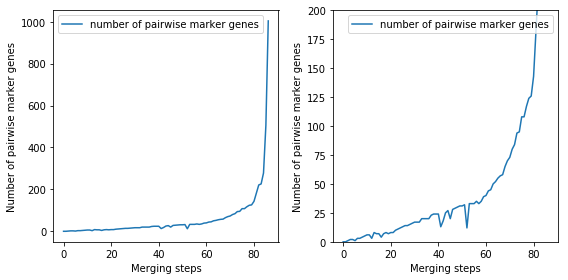

In [124]:
# QC
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
ax = axs[0]
ax.plot(Z['distance'].values, label='number of pairwise marker genes')
ax.set_xlabel('Merging steps')
ax.set_ylabel('Number of pairwise marker genes')
ax.legend()
ax = axs[1]
ax.plot(Z['distance'].values, label='number of pairwise marker genes')
ax.set_xlabel('Merging steps')
ax.set_ylabel('Number of pairwise marker genes')
ax.set_ylim([0, 200])
# ax.set_ylim([0, 1000])
# ax.set_yscale('log')
# ax.plot(Z_mono['distance'].values, label='number of pairwise marker genes (Dips removed)')
ax.legend()
fig.tight_layout()
plt.show()

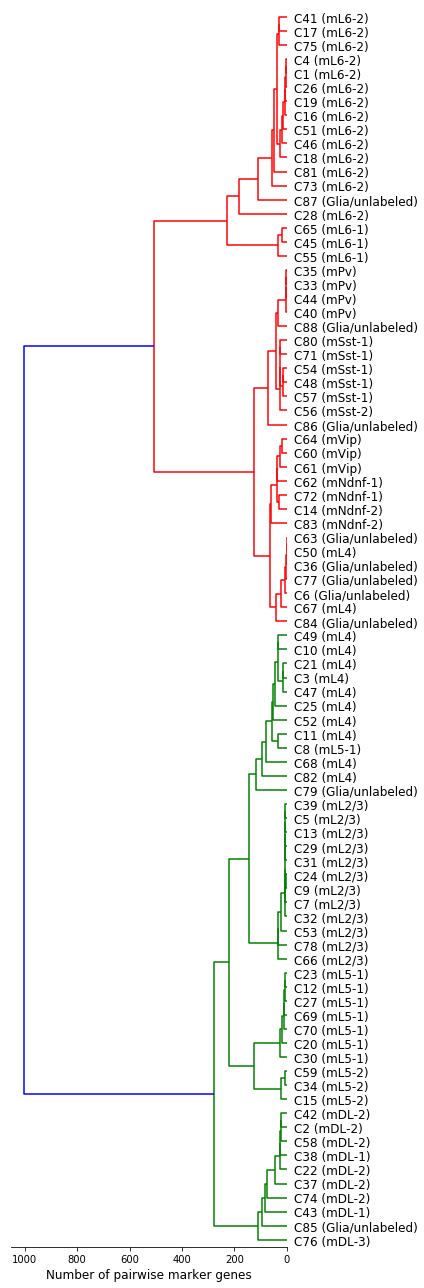

In [108]:
from scipy.cluster.hierarchy import dendrogram

fig, ax = plt.subplots(figsize=(6, 18))
dendrogram(Z_mono[['c1', 'c2', 'distance', 'num_orig_clusters']].values.astype(np.float), orientation='left', ax=ax)
ax.set_yticklabels(
    ['C{} ({})'.format(int(label.get_text())+1, df_annot.loc[int(label.get_text())+1, 'annotation_'+cluster_type])
     for label in ax.get_yticklabels()], 
    fontsize=12)
ax.set_xlabel('Number of pairwise marker genes', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
fig.tight_layout()
fig.savefig('/cndd/fangming/integration/88_clusters_dendrogram.pdf')
plt.show()

# Compare it with a direct hierarchical clustering on genebody mCH (select top variant ones)

In [100]:
df_mcc.head()
df_mcc.shape
data.shape
data_pct.shape

(25118, 88)

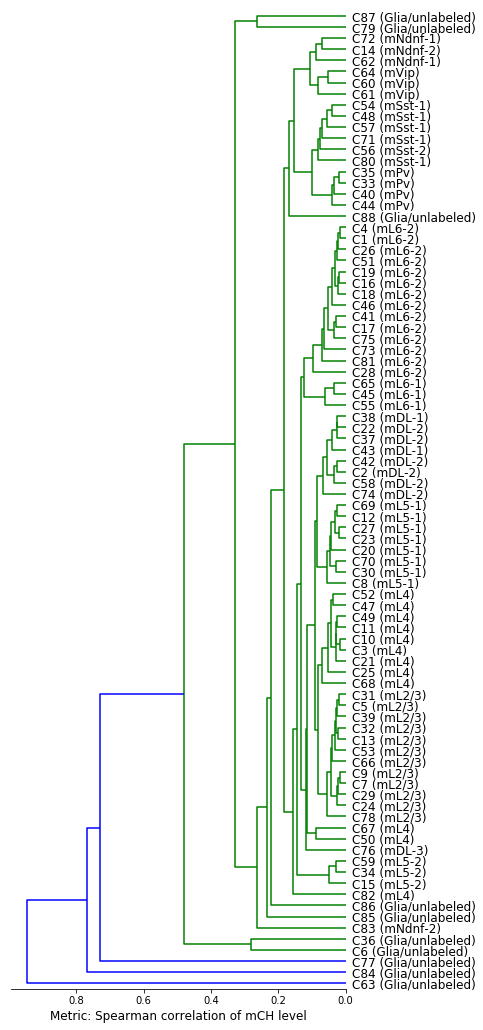

In [107]:
Z = sch.linkage(df_mcc.rank(pct=True, axis=0).T, method='average', metric='correlation')
fig, ax = plt.subplots(figsize=(6, 18))
sch.dendrogram(Z, ax=ax, orientation='left')
ax.set_yticklabels(
    ['C{} ({})'.format(int(label.get_text())+1, df_annot.loc[int(label.get_text())+1, 'annotation_'+cluster_type])
     for label in ax.get_yticklabels()], 
    fontsize=12)
ax.set_xlabel('Metric: Spearman correlation of mCH level', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()